# Etude du Prix des Billets SNCF

## Sommaire:

- [I - Before Starting](#title-1)
    - [1. Loading Libraries](#title-1-1)
    - [2. Usefull Functions](#title-1-2)
    - [3. Loading Datas](#title-1-3)
- [II - Choosing the Hour](#title-2)
    - [1. L'Aller](#title-2-1)
    - [2. Le Retour](#title-2-2)
- [III - Evolution du prix d'un billet au cours du temps](#title-3)

# I - Before Starting <a name="title-1">

---

## 1. Loading Libraries <a name="title-1-1">

In [1]:
import json 
import pandas as pd
from pandas.io.json import json_normalize
import matplotlib.pyplot as plt
import seaborn as sns
import os
from math import *

## 2. Usefull Functions <a name="title-1-2">

**get_datas_from_departure:** permet de sélectionner des informations à partir de la date et l'heure de départ.

In [2]:
def get_datas_from_departure(datas, day="false", month="false", year="false", hour="false", minute="false"):
    to_concat = []
    if day != "false":
        to_concat.append(datas["departureDate.date.day"] == day)
    if month != "false":
        to_concat.append(datas["departureDate.date.month"] == month)
    if year != "false":
        to_concat.append(datas["departureDate.date.year"] == year)
    if hour != "false":
        to_concat.append(datas["departureDate.hours.hour"] == hour)
    if minute != "false":
        to_concat.append(datas["departureDate.hours.minute"] == minute)
        
    return datas[pd.concat(to_concat, axis=1).all(axis=1)]

**get_datas_from_departure:** permet de sélectionner des informations à partir de la date et l'heure de collecte.

In [3]:
def get_datas_from_collect(datas, day="false", month="false", year="false", hour="false", minute="false"):
    to_concat = []
    if day != "false":
        to_concat.append(datas["collectDate.date.day"] == day)
    if month != "false":
        to_concat.append(datas["collectDate.date.month"] == month)
    if year != "false":
        to_concat.append(datas["collectDate.date.year"] == year)
    if hour != "false":
        to_concat.append(datas["collectDate.hours.hour"] == hour)
    if minute != "false":
        to_concat.append(datas["collectDate.hours.minute"] == minute)
        
    return datas[pd.concat(to_concat, axis=1).all(axis=1)]

**add_colleced_date:** ajoute la date de collecte des données à un dataframe à partir du nom du fichier collecté

In [4]:
def add_collected_date(datas, file_name):
    name = file_name.split(".json")[0]
    name = name.split("T")
    date = name[0].split("-")
    hours = name[1].split("-")
    
    datas["collectDate.date.year"] = date[0]
    datas["collectDate.date.month"] = date[1]
    datas["collectDate.date.day"] = date[2]
    datas["collectDate.hours.hour"] = hours[0]
    datas["collectDate.hours.minute"] = hours[1]
    return datas
    

**dispay_datas_in_time:** On donne les données en entré et la fonction trace un graphe

In [5]:
def display_datas_in_time(datas, hour):
    #On récupère la liste des dates contenues dans le dataframe
    
    mean = datas[pd.concat([datas["type"] == "SEMIFLEX", datas["departureDate.hours.hour"] == hour], axis=1).all(axis=1)]["amount"].mean()
    median = datas[pd.concat([datas["type"] == "SEMIFLEX", datas["departureDate.hours.hour"] == hour], axis=1).all(axis=1)]["amount"].median()
    
    liste_dates = sorted(set([i for i in zip(datas["departureDate.date.month"], datas["departureDate.date.day"])]))
    fig, ax = plt.subplots(figsize=(20,10))
    for date in liste_dates:
        datasx = get_datas_from_departure(datas, year="2018", month=date[0], day=date[1], hour=hour)
        liste_prices = datasx[datasx["type"] == "SEMIFLEX"]["amount"]
        label = date[1]+"/"+date[0]
        ax.plot(range(len(liste_prices)), liste_prices, label=label)

    liste_dates_collected = sorted(set([i for i in zip(datas["collectDate.date.month"], datas["collectDate.date.day"])]))
    for index in range(len(liste_dates_collected)):
        x=(index+1)*3-0.5
        color = "grey"
        if (index+1) % 5 == 0:
            color = "red"
        plt.axvline(x=x, color=color, linewidth=1, linestyle="--")
    plt.axhline(y=mean, color="grey", linewidth=1, linestyle="--")
    plt.axhline(y=median, color="blue", linewidth=1, linestyle="--")
    
    ax.legend(fontsize='x-large')
    plt.show()

**semiflex_only:** retourne seulement les données pour les billets semi-flex

In [6]:
def semiflex_only(datas):
    return datas[datas["type"] == "SEMIFLEX"]

In [7]:
def compare_prices(datas, first_hour, second_hour):
    datas_first = semiflex_only(get_datas_from_departure(datas, hour=first_hour))
    datas_second = semiflex_only(get_datas_from_departure(datas, hour=second_hour))

    total_price_first = datas_first["amount"].sum()
    total_price_second = datas_second["amount"].sum()

    for date_departure in liste_dates_aller:
        for date_collect in liste_dates_collect:
            datas = semiflex_only(get_datas_from_departure(datas_first, year="2018", month=date_departure[0], day=date_departure[1], hour=first_hour))
            datas1 = get_datas_from_collect(datas, year="2018", month=date_collect[0], day=date_collect[1], hour=date_collect[2], minute=date_collect[3])
            datas = semiflex_only(get_datas_from_departure(datas_second, year="2018", month=date_departure[0], day=date_departure[1], hour=second_hour))
            datas2 = get_datas_from_collect(datas, year="2018", month=date_collect[0], day=date_collect[1], hour=date_collect[2], minute=date_collect[3])
            if datas1.shape[0] == 0 and datas2.shape[0] != 0:
                total_price_second -= datas2["amount"].values[0]
            if datas1.shape[0] != 0 and datas2.shape[0] == 0:
                total_price_first -= datas1["amount"].values[0]

    return total_price_first - total_price_second

## 3. Loading Datas <a name="title-1-3">

On commence par importer toutes les données collectées durant les jours précédents.

In [8]:
#Collecte des données de l'aller
datas_aller = []
file_list = os.listdir("datas/aller")
for file_name in file_list:
    with open("datas/aller/"+file_name) as file:
        datas = json.load(file)
    datas = json_normalize(datas["trainProposals"])
    datas = add_collected_date(datas, file_name)
    datas_aller.append(datas)    
datas_aller = pd.concat(datas_aller)


#Collecte des données du retour
datas_retour = []
file_list = os.listdir("datas/retour")
for file_name in file_list:
    with open("datas/retour/"+file_name) as file:
        datas = json.load(file)
    datas = json_normalize(datas["trainProposals"])
    datas = add_collected_date(datas, file_name)
    datas_retour.append(datas)    
datas_retour = pd.concat(datas_retour)

#On crée une variable qui contient la liste des dates
liste_dates_aller = sorted(set([i for i in zip(datas_aller["departureDate.date.month"], datas_aller["departureDate.date.day"])]))
liste_dates_retour = sorted(set([i for i in zip(datas_retour["departureDate.date.month"], datas_retour["departureDate.date.day"])]))
liste_dates_collect = sorted(set([i for i in zip(datas_aller["collectDate.date.month"], datas_aller["collectDate.date.day"], datas_aller["collectDate.hours.hour"], datas_aller["collectDate.hours.minute"])]))

# II - Choosing the Hour <a name="title-2">
    
---

<div style="text-align:justify;">Que ce soit pour l'aller ou pour le retour, je peux admettre un peu de flexibilité pour le choix de l'heure du départ du train. Le nombre d'horaires considérés est juste assez grand pour qu'une étude soit intéressante mais juste assez faible pour que cette étude ne soit pas un casse tête.</div>

<div style="text-align:justify;"><br>Deux critères ont été pris en compte pour cette étude: Le prix du billet, ainsi que mes préférence d'horaire pour divers raisons personnelles issues de mes premières expériences de trajets.</div>

## 1. L'Aller <a name="title-2-1">

<div style="text-align:justify;">L'aller s'effectue le vendredi soir après mon travail. Je ne dispose pas d'horaires fixes et peux donc choisir mon heure de départ. Cependant je ne souhaite pas abuser dans ce choix. En effet, je quitte généralement mon travail à 17h30 et je ne souhaite pas que l'heure de départ du vendredi ne m'éloigne trop de cet horaire. Je décide donc de considérer les 3 horaires suivants accompagnés de commentaires personnels:</div>

- 16h36 : Légèrement troµp tôt pour quitter mon travail
- 17h37 : Horaire privilégié
- 19h32 : Arrivée trop tard

<div style="text-align:justify;">Commençons par vizualiser nos données afin d'avoir une première intuition sur le concepte étudié. Je décide de tracer un ensemble de graphes répartis sur une grille. Chaque graphe correspond à un jour de départ de train différent (chaque vendredi). Sur chaque graphe il y a 3 courbes. Elles représentent l'évolution du prix enregistré au cours du temps pour chaque horaire considéré.</div>

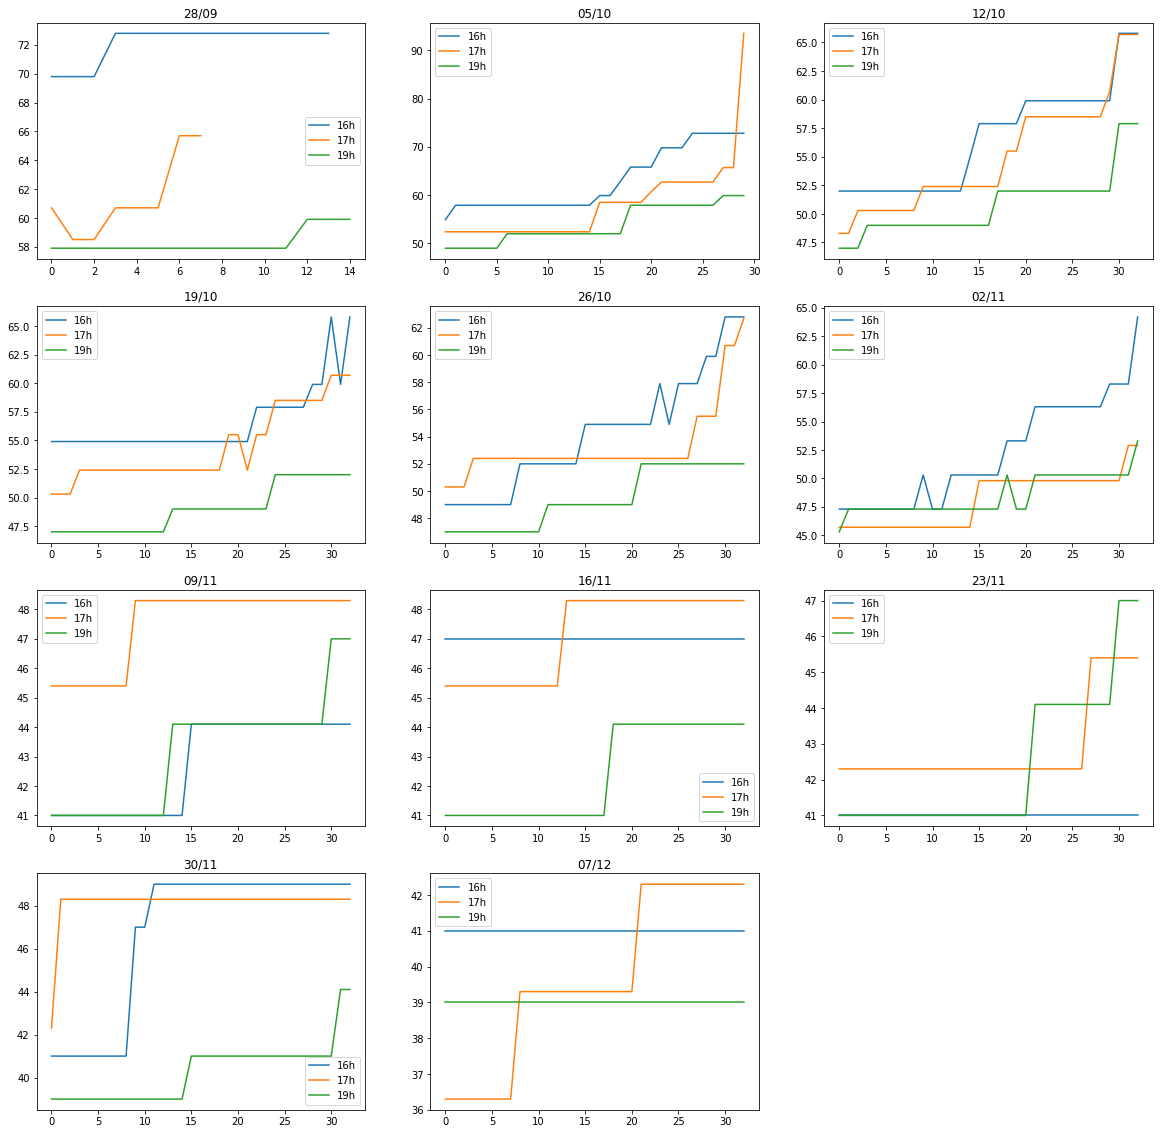

In [9]:
# ---- Variables to choose ----
list_hours_aller = ["16", "17", "19"]  #liste des heures considérées
cols = 3                               #nombre de graphes par lignes
# -----------------------------
rows = ceil(len(liste_dates_aller)/cols)

fig = plt.figure(figsize=(20,20))
#For each friday considered
for index, date in enumerate(liste_dates_aller):
    ax = fig.add_subplot(rows, cols, (index+1))
    
    #For each hour considered
    for hour in list_hours_aller:
        #We get all the datas
        datas = semiflex_only(get_datas_from_departure(datas_aller, year="2018", month=date[0], day=date[1], hour=hour))["amount"]
        #We plot it
        ax.plot(range(len(datas)), datas, label=hour+"h")
        
    ax.set_title(date[1]+"/"+date[0])
    ax.legend()
    
plt.show()

<div style="text-align:justify">On observe que selon les instants considérés, l'ordre des heures classé par prix n'est pas toujours le même. Une tendance générale semble se dégager. En effet, il semble que les trains de 16h soient plus chers que ceux de 17h et qu'eux même soient plus chers que ceux de 19h.</div>

<div style="text-align:justify;" class="alert alert-info">**Ma décision à partir de cette information:** Le trajet de 16h n'a aucun avantage par rapport aux autres trajets. Je ne le prend donc jamais. Je privilégie le trajet de 17h, plus convénient et de bon compromis. Cependant le trajet de 19h peut parfois être plus avantageux si la différence de prix est considérable (> 5 euros).</div>

<div style="text-align:justify"><br>Ces intuitions ne sont pas sufisantes pour être sur de la bonne décision à prendre. Je choisi donc d'étudier ces même données avec une autre méthodologie pour avori un autre point de vue.</div>

#### Méthodologie:
<div style="text-align:justify">Pour chaque horaire, on fait la somme des prix de tous les billets enregistrés. On compare ensuite cette donnée. Pour que cette comparaison soit la plus intéressante possible, il faut également tenir compte des cas où des billets sont disponibles pour certains horaires mais pas pour d'autres. Je choisi donc de ne pas ajouter les prix des billets lorsqu'il n'y a pas 3 billets disponibles à certaines périodes. Je décide également de ne comparer les billets que deux à deux.</div>

In [10]:
dif1 = compare_prices(datas_aller, "16", "17")
dif2 =compare_prices(datas_aller, "16", "19")
print("dif(16h, 17h) = {:.2f}".format(dif1))
print("dif(16h, 19h) = {:.2f}".format(dif2))

dif(16h, 17h) = 292.50
dif(16h, 19h) = 1557.40


En terme de prix de billets:
- 16h > 17h
- 16h > 19h

Les billets de 16h sont donc bien les plus chers.

In [11]:
dif = compare_prices(datas_aller, "17", "19")
print("dif(17h, 19h) = {:.2f}".format(dif))

dif(17h, 19h) = 1179.50


- 17h > 19h

### Bilan:
<div>19h < 17h < 16h</div>
<div style="text-align:justify;">la différence entre les billets de 16h et de 17h est relativement faible par rapport à celle entre les billets de 17h et ceux de 19h. Il est donc important de tenir compte des billets de 19h même si cet horaire n'est pas toujours pratique.</div>

## 2. Le Retour <a name="title-2-2">
Des problématiques simmilaires à l'aller existent pour le choix du billet de retour. J'utiliserai donc les mêmes méthodologies que celles employées pour l'étude des prix des billets pour l'aller. Les horaires considérés pour ce trajet sont les suivants:

- 14h52 : Trop tôt
- 16h52 : Un peut trop tôt
- 17h52 : Horaire satisfaisant
- 18h52 : Horaire satisfaisant


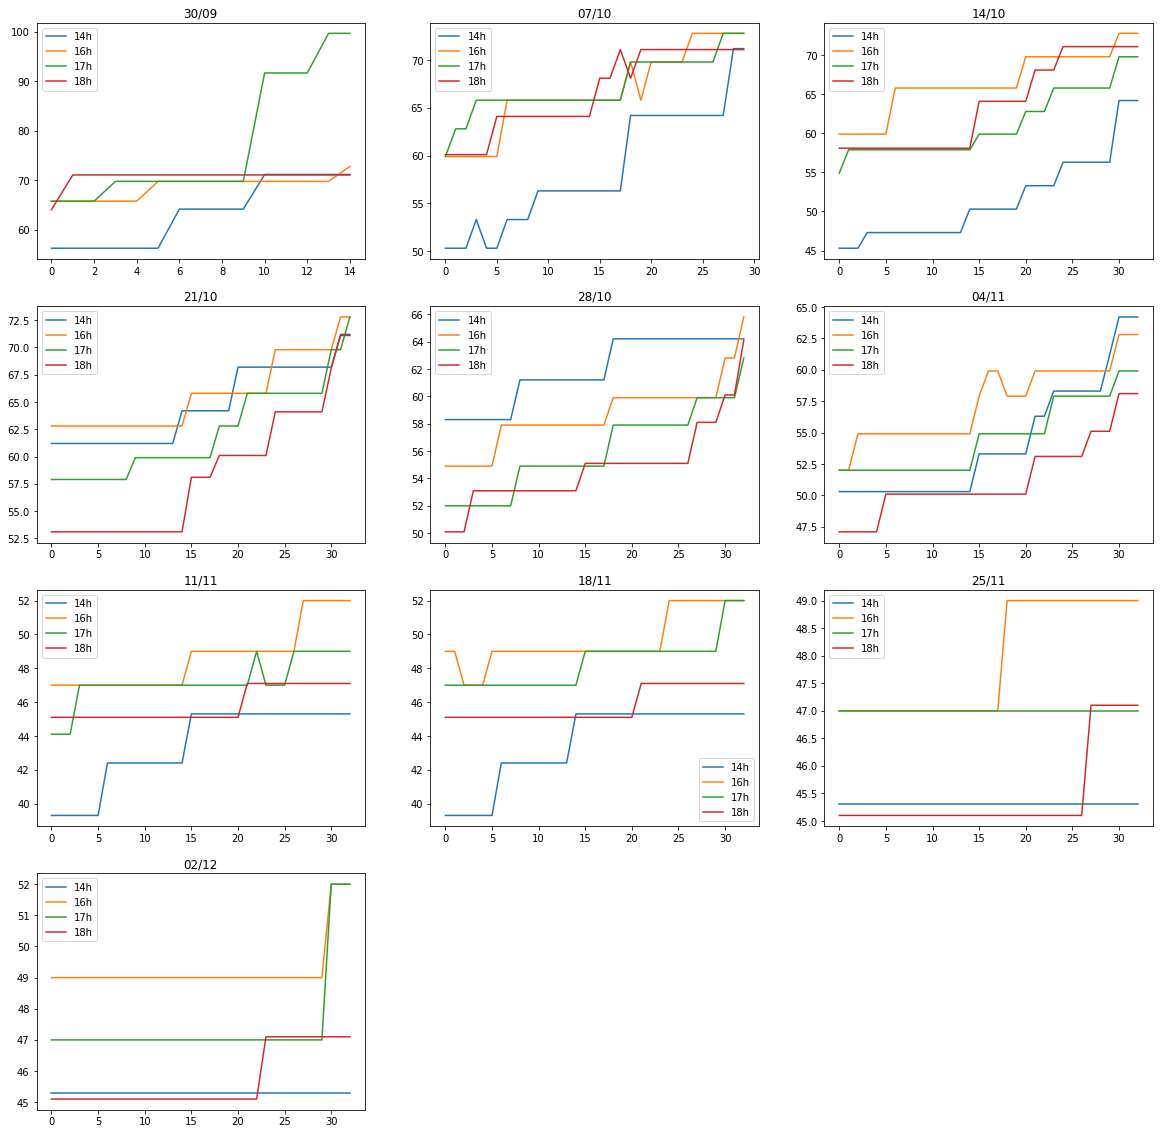

In [12]:
# ---- Variables to choose ----
list_hours_retour = ["14", "16", "17", "18"] #liste des heures considérées
cols = 3                                     #nombre de graphes par lignes
# ----------------------------- 
rows = ceil(len(liste_dates_aller)/cols)

fig = plt.figure(figsize=(20,20))
#For each sunday considered
for index, date in enumerate(liste_dates_retour):
    ax = fig.add_subplot(rows, cols, (index+1))
    
    #For each hour considered
    for hour in list_hours_retour:
        #We get all the datas
        datas = semiflex_only(get_datas_from_departure(datas_retour, year="2018", month=date[0], day=date[1], hour=hour))["amount"]
        #We plot it
        ax.plot(range(len(datas)), datas, label=hour+"h")
        
    ax.set_title(date[1]+"/"+date[0])
    ax.legend()
    
plt.show()

<div style="text-align:justify">Il est plus difficil d'effectuer des observations générales avec 4 courbes. Il semble cependant que le trajet de 16h soit généralement le plus cher. A l'opposer, le trajet de 14h semble moins attirer les acheteurs et propose donc des prix moins grands que les autres. Les billets proposés aux horaires de 17h et 18h semble alterner entre la 2e et la 3e position du classement du prix le plus cher.</div>

<div style="text-align:justify;" class="alert alert-info">**Ma décision à partir de cette information:**  Privilégier les billets proposés à 17h et 18h. Suivre le prix du billet de 14h dans les cas où le prix soit vraiment inréressant par rapport aux autres.</div>

In [13]:
dif1 = compare_prices(datas_retour, "14", "16")
dif2 = compare_prices(datas_retour, "14", "17")
dif3 = compare_prices(datas_retour, "14", "18")
print("dif(14h, 16h) = {:.2f}".format(dif1))
print("dif(14h, 17h) = {:.2f}".format(dif2))
print("dif(14h, 18h) = {:.2f}".format(dif3))

dif(14h, 16h) = -1444.20
dif(14h, 17h) = -947.30
dif(14h, 18h) = -388.10


- 14h < 16h
- 14h < 17h
- 14h < 18h

Le trajet de 14h est le moins cher de façon générale

In [14]:
dif1 = compare_prices(datas_retour, "16", "17")
dif2 =compare_prices(datas_retour, "16", "18")
print("dif(16h, 17h) = {:.2f}".format(dif1))
print("dif(16h, 18h) = {:.2f}".format(dif2))

dif(16h, 17h) = 496.90
dif(16h, 18h) = 1056.10


- 16h > 17h
- 16h > 18h

Le trajet de 16h est le plus cher de façon générale

In [15]:
dif = compare_prices(datas_retour, "17", "18")
print("dif(17h, 18h) = {:.2f}".format(dif))

dif(17h, 18h) = 559.20


- 17h > 18h

Le trajet de 17h est plus cher que celui de 18h

### Bilan:
<div>14h < 18h < 17h < 16h</div>
<div style="text-align:justify;">Il faut privilégier le trajet de 18h par rapport à celui de 17h, mais surveiller ces deux horaires en fonction du billet à acheter. Le billet de 14h peut être choisi dans les cas extrême où le prix proposé est très différent de celui des deux autres. Dans les autres cas, le billet de 14h n'est pas assez pratique pour être intéressant à chaque fois.</div>

# III - Evolution du prix d'un billet au cours du temps <a name="title-3">
    
----

<div style="text-align:justify;">Pour continuer notre exploration des données collectées, nous allons essayer de savoir quel est le meilleur moment pour acheter un billet. J'ai de nombreuses question à ce sujet. Le prix des billets est-il mis à jours à une heure précise de la journée ou évolue-t-il avec la demande en direct durant la journée? Combien de temps avant le départ du train peut on acheter un billet?</div>

<div style="text-align:justify;"><br>Pour répondre à ces questions, je décide de tracer sur un même graphe tous les jours considérés. Chaque courbe correspond à l'évolution au cours du temps du prix des billets pour une heure et un jour donné. Les traits verticaux en pointillé correspondent aux jours de la semaine. Ceux en rouge marquent la fin d'une semaine. En effet, je ne relève pas de données durant le week-end. J'ai également tracé horizontalement la médiane (bleu ) et la moyenne (gris).</div>

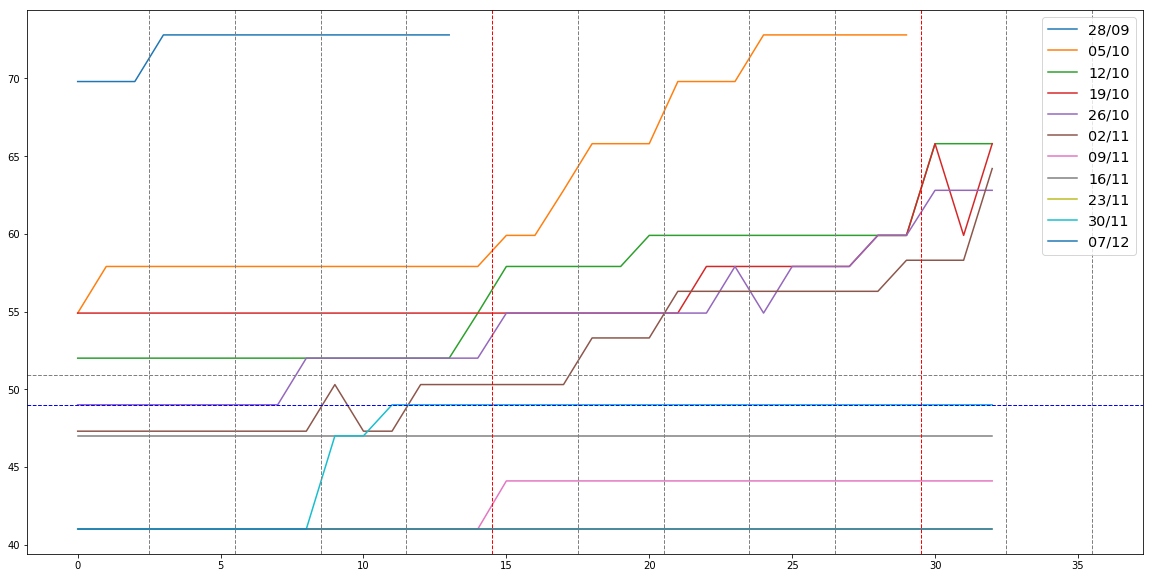

		Trajet Lannion-Paris à 16h


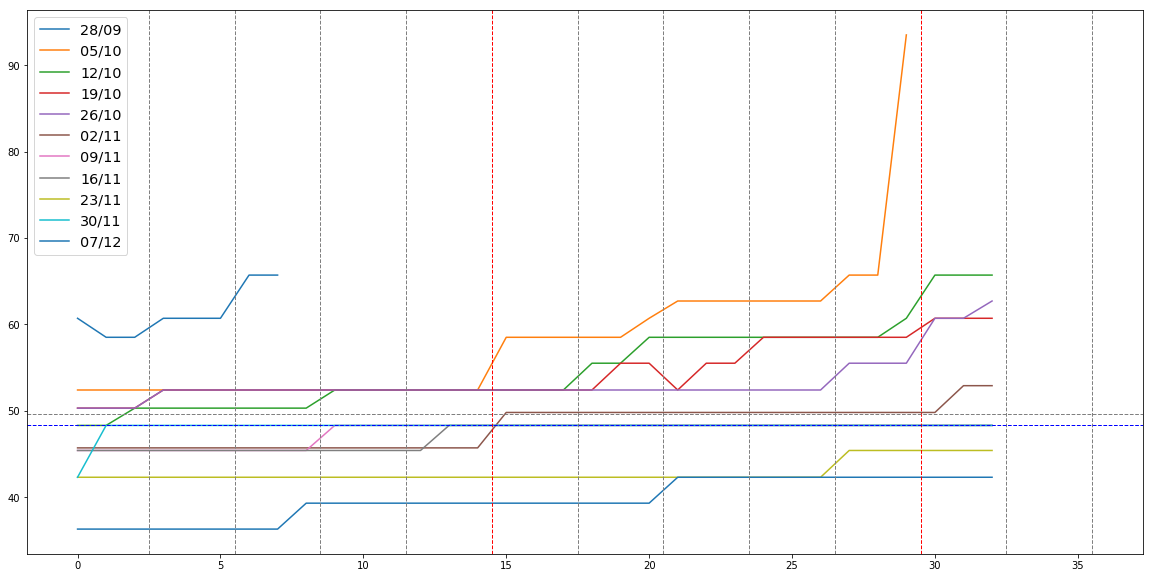

		Trajet Lannion-Paris à 17h


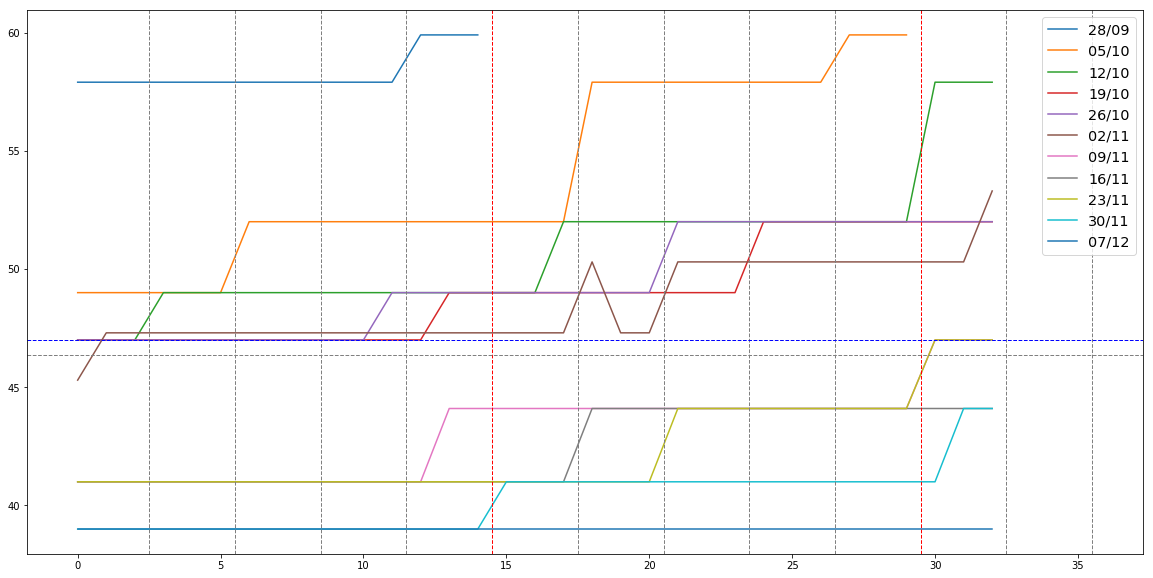

		Trajet Lannion-Paris à 19h


In [16]:
display_datas_in_time(datas_aller, "16")
print("\t\tTrajet Lannion-Paris à 16h")
display_datas_in_time(datas_aller, "17")
print("\t\tTrajet Lannion-Paris à 17h")
display_datas_in_time(datas_aller, "19")
print("\t\tTrajet Lannion-Paris à 19h")

In [17]:
semiflex_only(get_datas_from_departure(datas_aller, year="2018", month="10", day="26", hour="17"))[["amount", "collectDate.date.day", "collectDate.hours.hour", "collectDate.hours.minute"]]

,amount,collectDate.date.day,collectDate.hours.hour,collectDate.hours.minute
157,50.3,24,11,28
157,50.3,24,14,30
157,50.3,24,17,31
162,52.4,25,09,22
162,52.4,25,12,23
161,52.4,25,15,24
161,52.4,26,09,16
161,52.4,26,12,17
157,52.4,26,15,18
157,52.4,27,09,27


In [18]:
datas = get_datas_from_departure(datas_aller, year="2018", month="10", day="12", hour="19")
datas = datas[datas["type"] == "SEMIFLEX"]
#datas[["amount", "arrivalDate.date.month", "arrivalDate.date.day", "arrivalDate.hours.minute"]]
datas

,amount,arrivalDate.date.day,arrivalDate.date.month,arrivalDate.date.year,arrivalDate.hours.hour,arrivalDate.hours.minute,departureDate.date.day,departureDate.date.month,departureDate.date.year,departureDate.hours.hour,...,remainingSeat1,remainingSeat2,travelClass1,travelClass2,type,collectDate.date.year,collectDate.date.month,collectDate.date.day,collectDate.hours.hour,collectDate.hours.minute
96,47.0,12,10,2018,23,13,12,10,2018,19,...,99,1,SECOND,SECOND,SEMIFLEX,2018,09,24,11,28
96,47.0,12,10,2018,23,13,12,10,2018,19,...,99,1,SECOND,SECOND,SEMIFLEX,2018,09,24,14,30
96,47.0,12,10,2018,23,13,12,10,2018,19,...,99,1,SECOND,SECOND,SEMIFLEX,2018,09,24,17,31
101,49.0,12,10,2018,23,13,12,10,2018,19,...,99,21,SECOND,SECOND,SEMIFLEX,2018,09,25,09,22
101,49.0,12,10,2018,23,13,12,10,2018,19,...,99,22,SECOND,SECOND,SEMIFLEX,2018,09,25,12,23
100,49.0,12,10,2018,23,13,12,10,2018,19,...,99,22,SECOND,SECOND,SEMIFLEX,2018,09,25,15,24
100,49.0,12,10,2018,23,13,12,10,2018,19,...,99,21,SECOND,SECOND,SEMIFLEX,2018,09,26,09,16
100,49.0,12,10,2018,23,13,12,10,2018,19,...,99,20,SECOND,SECOND,SEMIFLEX,2018,09,26,12,17
96,49.0,12,10,2018,23,13,12,10,2018,19,...,99,20,SECOND,SECOND,SEMIFLEX,2018,09,26,15,18
96,49.0,12,10,2018,23,13,12,10,2018,19,...,99,18,SECOND,SECOND,SEMIFLEX,2018,09,27,09,27


économie: 6.1 euros

Ci-dessus est affiché l'évolution du prix au cours d'une semaine. Cela a commencé Lundi 24 septembre et les données ont été collectées tous les jours de la semaine. Aucune données n'a été collectée le week-end.

On constate l'existence de "palliers" de prix. En effet, les prix semblent prendre des valeurs discrètes. On constate de légère variation dans cette règle, comme c'est le cas entre la courbe du 16/11 et celle du 02/11.

Les variations au cours de la journée sont rares. En effet sur les 9 jours étudiés, on constate seulement 3 variations du prix ai cours de journées. Il ne faut pas compter les variation de prix en début de journée. Ces variations ont en effet eu lieu la nuit.

Les variations de prix se font par pallier. Le seul cas ou un pallier a été sauté est durant le week-end ou je n'est pas mesuré d'informations durant deux jours consécutifs.

# Quels sont ces palliers?

Commençon par sélectionner les données sur lesquelles on travail. A savoir les billets SEMIFLEX de 17h sur le trajet aller.

In [19]:
palliers_aller = datas_aller[pd.concat([datas_aller["type"] == "SEMIFLEX", datas_aller["departureDate.hours.hour"] == "17"], axis=1).all(axis=1)]
display(palliers_aller[["amount", "type"]].groupby(["amount"], as_index=False).count().sort_values(by="type", ascending=False))

palliers_retour = datas_retour[pd.concat([datas_retour["type"] == "SEMIFLEX", datas_retour["departureDate.hours.hour"] == "17"], axis=1).all(axis=1)]
display(palliers_retour[["amount", "type"]].groupby(["amount"], as_index=False).count().sort_values(by="type", ascending=False))

,amount,type
5,48.3,78
8,52.4,65
2,42.3,40
3,45.4,28
11,58.5,22
6,49.8,16
4,45.7,15
1,39.3,13
7,50.3,13
12,60.7,11


,amount,type
1,47.0,100
5,57.9,39
8,65.8,34
3,52.0,29
2,49.0,23
6,59.9,23
9,69.8,21
4,54.9,19
7,62.8,9
10,72.8,4


# IV - Random Tests

In [20]:
datas = get_datas_from_departure(datas_aller, day=date[1], month=date[0], year="2018")
datas = datas[datas["type"] == "SEMIFLEX"]
display(datas[datas["departureDate.hours.hour"] == "17"])
datas[datas["departureDate.hours.hour"] == "19"][["arrivalDate.hours.hour", "arrivalDate.hours.minute", "departureDate.hours.hour", "departureDate.hours.minute", "collectDate.date.day", "collectDate.date.month"]]

,amount,arrivalDate.date.day,arrivalDate.date.month,arrivalDate.date.year,arrivalDate.hours.hour,arrivalDate.hours.minute,departureDate.date.day,departureDate.date.month,departureDate.date.year,departureDate.hours.hour,...,remainingSeat1,remainingSeat2,travelClass1,travelClass2,type,collectDate.date.year,collectDate.date.month,collectDate.date.day,collectDate.hours.hour,collectDate.hours.minute


,arrivalDate.hours.hour,arrivalDate.hours.minute,departureDate.hours.hour,departureDate.hours.minute,collectDate.date.day,collectDate.date.month


Mon idée est de créer le même tableau mais à la place du prix, amount contiendra la différence entre le prix de 19h et celui de 17h (challenge).

In [21]:
datas_aller[pd.concat([datas_aller["arrivalDate.hours.hour"] == "23", datas_aller["arrivalDate.hours.minute"] == "09"], axis=1).all(axis=1)]

,amount,arrivalDate.date.day,arrivalDate.date.month,arrivalDate.date.year,arrivalDate.hours.hour,arrivalDate.hours.minute,departureDate.date.day,departureDate.date.month,departureDate.date.year,departureDate.hours.hour,...,remainingSeat1,remainingSeat2,travelClass1,travelClass2,type,collectDate.date.year,collectDate.date.month,collectDate.date.day,collectDate.hours.hour,collectDate.hours.minute
128,47.0,19,10,2018,23,09,19,10,2018,19,...,99,19,SECOND,SECOND,SEMIFLEX,2018,09,24,11,28
129,51.0,19,10,2018,23,09,19,10,2018,19,...,99,2,SECOND,FIRST,UPSELL,2018,09,24,11,28
130,93.2,19,10,2018,23,09,19,10,2018,19,...,99,124,SECOND,SECOND,FLEX,2018,09,24,11,28
160,47.0,26,10,2018,23,09,26,10,2018,19,...,99,15,SECOND,SECOND,SEMIFLEX,2018,09,24,11,28
161,53.9,26,10,2018,23,09,26,10,2018,19,...,99,1,SECOND,FIRST,UPSELL,2018,09,24,11,28
162,93.2,26,10,2018,23,09,26,10,2018,19,...,99,119,SECOND,SECOND,FLEX,2018,09,24,11,28
192,45.3,02,11,2018,23,09,02,11,2018,19,...,99,1,SECOND,SECOND,SEMIFLEX,2018,09,24,11,28
193,52.3,02,11,2018,23,09,02,11,2018,19,...,99,3,SECOND,FIRST,UPSELL,2018,09,24,11,28
194,93.2,02,11,2018,23,09,02,11,2018,19,...,99,106,SECOND,SECOND,FLEX,2018,09,24,11,28
230,38.8,09,11,2018,23,09,09,11,2018,19,...,99,9,SECOND,SECOND,NOFLEX,2018,09,24,11,28


**Découverte**: L'heure d'arriver du trajet de train Lannion-Paris de 23h change de 19h09 à 19h13 au cours du temps sans raison apparente. 